# Simple Usage

## 1. Voigt profile

In [1]:
import numpy
import matplotlib.pyplot as plt
from exojax.spec import voigt

ExoJAX has both opacity calculators and radiative transfer algorithms. The basis of the former capacility is [the Voigt function](https://en.wikipedia.org/wiki/Voigt_profile), which is the convolution of a Gaussian and a Lorentian.



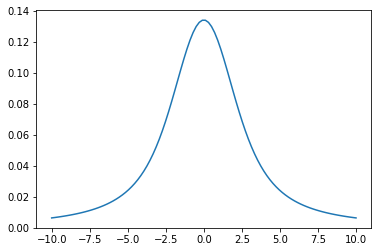

In [2]:
x=numpy.linspace(-10,10,100) 
y=voigt(x,1.0,2.0) #sigma_D=1.0, gamma_L=2.0
plt.plot(x,y)
plt.show()

## 2. Cross section

This software has many features, but the laziest use is to use spec.autospec. Let's try to compute the cross section of carbon monooxide.

In [3]:
from exojax.spec.autospec import AutoXS

ExoJAX automatically downloads a molecular database, convert it to the feather format and save it in .database directory.

In [4]:
nus=numpy.linspace(1900.0,2300.0,40000,dtype=numpy.float64) #wavenumber (cm-1)
autoxs=AutoXS(nus,"ExoMol","CO") #using ExoMol CO (12C-16O). HITRAN and HITEMP are also supported.  
xsv=autoxs.xsection(1000.0,1.0) #cross section for 1000K, 1bar (cm2)

Recommendated database by ExoMol:  Li2015
CO/12C-16O/Li2015
broadf= True
Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states


  0%|          | 0/19 [00:00<?, ?it/s]

# of lines= 3636
LPF selected


100%|██████████| 19/19 [00:01<00:00, 10.62it/s]


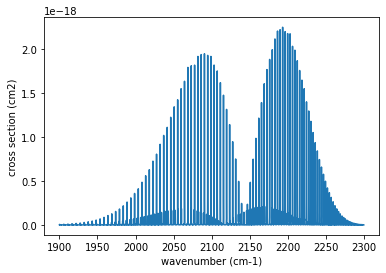

In [5]:
plt.plot(nus,xsv) #cm2
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

You can plot the line strengths. 

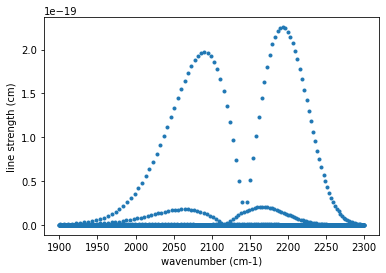

In [6]:
ls=autoxs.linest(1000.0) #line strength for 1000K
plt.plot(autoxs.mdb.nu_lines,ls,".")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("line strength (cm)")
plt.show()

ExoJAX can solve the radiative transfer and derive the emission spectrum. Let's try it using spec.autospec.AutRT

In [7]:
from exojax.utils.grids import wavenumber_grid
from exojax.spec.autospec import AutoRT

We need to assume a temperature-Pressure profile (T-P profile) to compute the emission spectrum. Here, we assume a power-law type T-P profile.
In addition to CO, we assume H2-H2 and H2-He [collisional induced absorption](https://en.wikipedia.org/wiki/Collision-induced_absorption_and_emission) (CIA) as a continuum opacity.

In [8]:
nus,wav,res=wavenumber_grid(1900.0,2300.0,150000,"cm-1")
Parr=numpy.logspace(-8,2,100)
Tarr = 500.*(Parr/Parr[-1])**0.02    
autort=AutoRT(nus,1.e5,2.33,Tarr,Parr) #g=1.e5 cm/s2, mmw=2.33
autort.addcia("H2-H2",0.74,0.74)       #CIA, mmr(H)=0.74
autort.addcia("H2-He",0.74,0.25)       #CIA, mmr(He)=0.25
autort.addmol("ExoMol","CO",0.01)      #CO line, mmr(CO)=0.01

xsmode assumes ESLOG in wavenumber space: mode=lpf
The wavenumber grid is evenly spaced in log space (ESLOG).
xsmode= auto
H2-H2
H2-He
Recommendated database by ExoMol:  Li2015
CO/12C-16O/Li2015
broadf= True
Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
# of lines 3636
# of lines= 3636
MODIT selected
xsmode= MODIT


/home/kawahara/exojax/src/exojax/spec/autospec.py:313: UserWarning: negative cross section detected #=3822040 fraction=0.2548026666666667
  warnings.warn(msg, UserWarning)


Let's run the radiative transfer.

In [9]:
F=autort.rtrun()

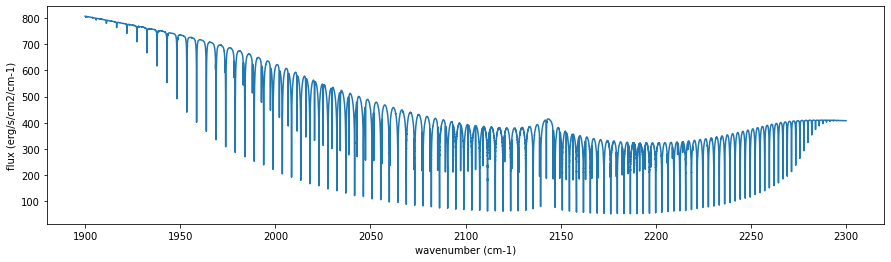

In [10]:
fig=plt.figure(figsize=(15,4))
plt.plot(nus,F)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

You may wanna take a planet spin rotation, RV shift, and observational sampling? Yes, we can.

In [11]:
nusobs=numpy.linspace(1900.0,2300.0,3000,dtype=numpy.float64) #observation wavenumber bin (cm-1)
Fobs=autort.spectrum(nusobs,100000.0,20.0,0.0) #R=100000, vsini=10km/s, RV=0km/s

This is just a convolution. So, you should ignore the edges.

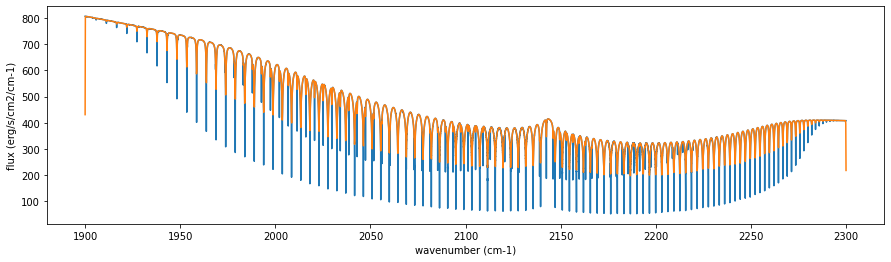

In [12]:
fig=plt.figure(figsize=(15,4))
plt.plot(nus,F)
plt.plot(nusobs,Fobs)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

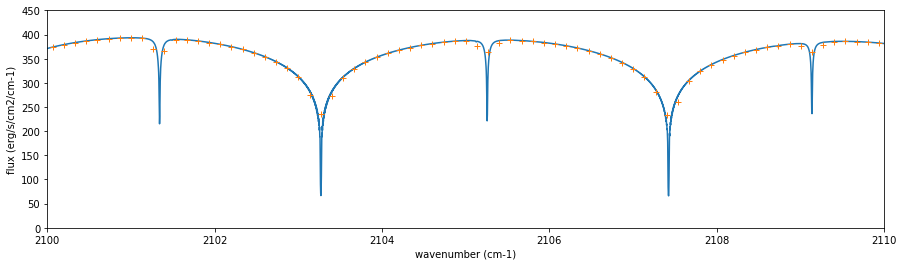

In [13]:
fig=plt.figure(figsize=(15,4))
plt.plot(nus,F)
plt.plot(nusobs,Fobs,"+")
plt.xlim(2100,2110)
plt.ylim(0,450)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

Visualize the contribution function to see where the emission comes from.

In [14]:
from exojax.plot.atmplot import plotcf

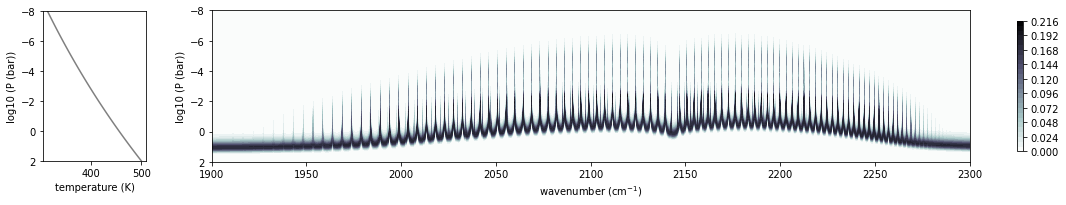

In [15]:
cf=plotcf(nus,autort.dtau,Tarr,Parr,autort.dParr)

That's it. 